## Notebook imports

In [1]:
from os import walk
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

%matplotlib inline

## Constants

In [2]:
SPAM_1_PATH = 'spam_1'
SPAM_2_PATH = 'spam_2'
EASY_HAM_1_PATH = 'easy_ham_1'
EASY_HAM_2_PATH = 'easy_ham_2'
HARD_HAM_PATH = 'hard_ham'

SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON_FILE = 'email-text-data.json'

THUMBS_UP_FILE = 'word_cloud/thumbs-up-solid.png'
THUMBS_DOWN_FILE = 'word_cloud/thumbs-down-solid.png'
FONT_PATH = 'word_cloud/font/Oswald-VariableFont_wght.ttf'

TRAINING_DATA_FILE = 'train-data.csv'
TEST_DATA_FILE = 'test-data.csv'

VOCAB_SIZE = 2500

## Creating the dataset

In [3]:
def email_body_generator(path):
    for root, dir_names, file_names in walk(path):
        for file_name in file_names:

            filepath = join(root, file_name)

            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [4]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [5]:
spam_emails = pd.concat([df_from_directory(SPAM_1_PATH, SPAM_CAT),
                         df_from_directory(SPAM_2_PATH, SPAM_CAT)])

ham_emails = pd.concat([df_from_directory(EASY_HAM_1_PATH, HAM_CAT),
                        df_from_directory(EASY_HAM_2_PATH, HAM_CAT)])

In [6]:
dataset = pd.concat([spam_emails, ham_emails])
dataset

,MESSAGE,CATEGORY
00194.767c323b4ae7a4909397e42cbd0c56a4,------=_NextPart_000_006C_6B8D6A65.3C3C56F\n\n...,1
00257.5c8ef87f8b11d2515df71a7fe46a70b6,NEWSLETTER COACHINVEST  SEPTEMBRE 2002\n\n\n...,1
00331.a61788d316e7393c8bbf8ee19b24c713,<HTML><HEAD><TITLE></TITLE><META http-equiv=3D...,1
00404.b4bbecbee92f735a845f589582e7695d,"\n\nWET, HORNY AND DIRTY GRANDMAS!\n\n\n\nReme...",1
00469.ee3b2f31459cc2ec43ae7cae00d40cf6,Lowest rates available for term life insurance...,1
...,...,...
00515.b39512509fd4f39fb1cf50248c37564f,"On Mon, 19 Aug 2002 12:01:02 BST, Adrian Murph...",0
00392.1b19fc79c0db6bf32f4736abacac5191,Two interesting analyses of the Irish implemen...,0
00792.0456a0df8da92cfb4d989b517ed0ff57,--==_Exmh_-603961349P\n\nContent-Type: text/pl...,0
00828.47851f2029854a0a9987c89b74a4c912,\n\nhow's about the String Joke?\n\n\n\nA piec...,0


In [7]:
document_ids = range(0, len(dataset))
dataset['ID'] = document_ids
dataset['FILE_NAME'] = dataset.index
dataset.set_index('ID', inplace=True)

In [8]:
dataset

,MESSAGE,CATEGORY,FILE_NAME
ID,,,
0,------=_NextPart_000_006C_6B8D6A65.3C3C56F\n\n...,1,00194.767c323b4ae7a4909397e42cbd0c56a4
1,NEWSLETTER COACHINVEST  SEPTEMBRE 2002\n\n\n...,1,00257.5c8ef87f8b11d2515df71a7fe46a70b6
2,<HTML><HEAD><TITLE></TITLE><META http-equiv=3D...,1,00331.a61788d316e7393c8bbf8ee19b24c713
3,"\n\nWET, HORNY AND DIRTY GRANDMAS!\n\n\n\nReme...",1,00404.b4bbecbee92f735a845f589582e7695d
4,Lowest rates available for term life insurance...,1,00469.ee3b2f31459cc2ec43ae7cae00d40cf6
...,...,...,...
5798,"On Mon, 19 Aug 2002 12:01:02 BST, Adrian Murph...",0,00515.b39512509fd4f39fb1cf50248c37564f
5799,Two interesting analyses of the Irish implemen...,0,00392.1b19fc79c0db6bf32f4736abacac5191
5800,--==_Exmh_-603961349P\n\nContent-Type: text/pl...,0,00792.0456a0df8da92cfb4d989b517ed0ff57


## Checking for empty emails

In [9]:
dataset['MESSAGE'].isnull().any(), (dataset['MESSAGE'].str.len() == 0).any()

(False, True)

In [10]:
rows_to_drop = list(dataset.loc[dataset['MESSAGE'].str.len() == 0].index)

dataset.drop(index=rows_to_drop, inplace=True)
dataset.reset_index(drop=True, inplace=True)
dataset.index.name = 'ID'

In [11]:
dataset

,MESSAGE,CATEGORY,FILE_NAME
ID,,,
0,------=_NextPart_000_006C_6B8D6A65.3C3C56F\n\n...,1,00194.767c323b4ae7a4909397e42cbd0c56a4
1,NEWSLETTER COACHINVEST  SEPTEMBRE 2002\n\n\n...,1,00257.5c8ef87f8b11d2515df71a7fe46a70b6
2,<HTML><HEAD><TITLE></TITLE><META http-equiv=3D...,1,00331.a61788d316e7393c8bbf8ee19b24c713
3,"\n\nWET, HORNY AND DIRTY GRANDMAS!\n\n\n\nReme...",1,00404.b4bbecbee92f735a845f589582e7695d
4,Lowest rates available for term life insurance...,1,00469.ee3b2f31459cc2ec43ae7cae00d40cf6
...,...,...,...
5794,"On Mon, 19 Aug 2002 12:01:02 BST, Adrian Murph...",0,00515.b39512509fd4f39fb1cf50248c37564f
5795,Two interesting analyses of the Irish implemen...,0,00392.1b19fc79c0db6bf32f4736abacac5191
5796,--==_Exmh_-603961349P\n\nContent-Type: text/pl...,0,00792.0456a0df8da92cfb4d989b517ed0ff57


#### Saving dataframe to json

In [12]:
dataset.to_json(DATA_JSON_FILE)

## Visualizing data

In [13]:
dataset['CATEGORY'].value_counts()

0    3900
1    1899
Name: CATEGORY, dtype: int64

In [14]:
amount_of_spam = dataset.CATEGORY.value_counts()[1]
amount_of_ham = dataset.CATEGORY.value_counts()[0]

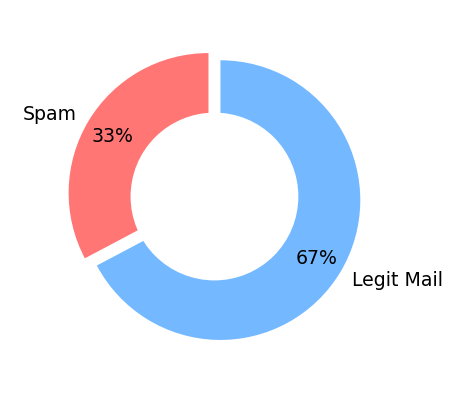

In [15]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']
offset = [0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8, explode=offset)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

## Creating the bag of words

In [16]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/kesley/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kesley/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer()

In [18]:
def clean_message(message):
    soup = BeautifulSoup(message, 'html.parser')
    words = soup.get_text().lower().split()
    filtered_words = []
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    return filtered_words

In [19]:
cleaned_messages = dataset['MESSAGE'].apply(clean_message)
print(len(cleaned_messages), len(dataset['CATEGORY']))

/home/kesley/anaconda3/envs/bayes/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/home/kesley/anaconda3/envs/bayes/lib/python3.10/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


5799 5799


In [20]:
list_ham = cleaned_messages.loc[dataset[dataset['CATEGORY'] == 0].index]
list_spam = cleaned_messages.loc[dataset[dataset['CATEGORY'] == 1].index]

In [21]:
flat_list_ham = []

for sublist in list_ham:
    for word in sublist:
        flat_list_ham.append(word)

In [22]:
flat_list_spam = []

for sublist in list_spam:
    for word in sublist:
        flat_list_spam.append(word)

## WordCloud

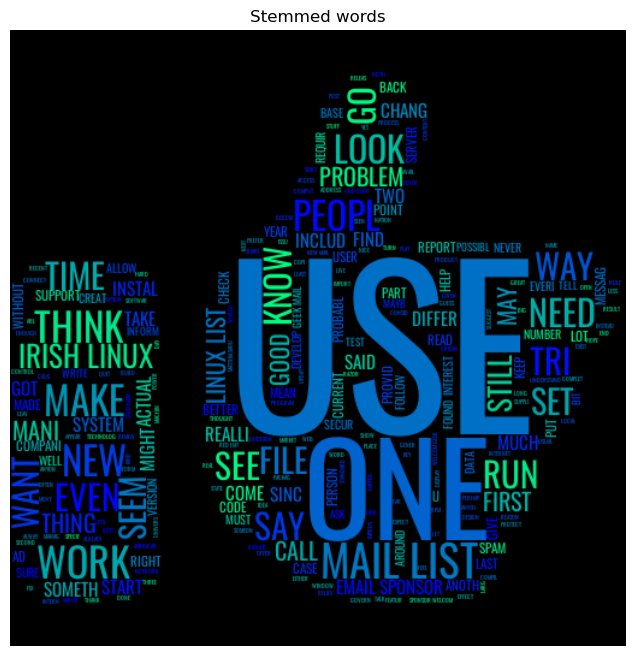

In [23]:
icon = Image.open(THUMBS_UP_FILE).convert('RGBA')

image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

# converts the image object to an array
rgb_array = np.array(image_mask)

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='black', max_font_size=300,
                      max_words=2000, colormap='winter', font_path=FONT_PATH)

word_cloud.generate(ham_str.upper())

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Stemmed words')
plt.show()

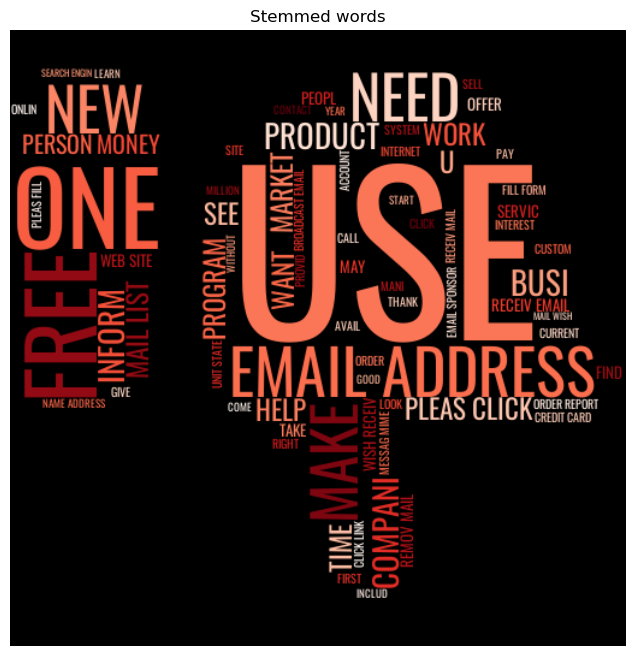

In [24]:
icon = Image.open(THUMBS_DOWN_FILE).convert('RGBA')

image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

# converts the image object to an array
rgb_array = np.array(image_mask)

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='black', max_font_size=300, 
                      max_words=2000, colormap='Reds', font_path=FONT_PATH)

word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Stemmed words')
plt.show()

## Creating the vocab

In [25]:
ham_bag = pd.Series(flat_list_ham)
spam_bag = pd.Series(flat_list_spam)

frequent_words = pd.concat([ham_bag, spam_bag]).value_counts()[:VOCAB_SIZE]

In [26]:
vocab = pd.DataFrame({'WORD': frequent_words.index.values})
vocab.index.name = 'ID'
vocab

,WORD
ID,
0,use
1,get
2,email
3,list
4,mail
...,...
2495,harder
2496,forb
2497,ping


## Train test split

In [27]:
x = pd.DataFrame(cleaned_messages.to_list())
y = dataset['CATEGORY'].reset_index(drop=True)

In [28]:
pd.concat([x, y], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,6187,6188,6189,6190,6191,6192,6193,6194,6195,CATEGORY
0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,1
1,newslett,septembr,de,jeun,entrepris,ou,coachinvest,de,nouvel,de,...,None,None,None,None,None,None,None,None,None,1
2,newslett,discov,winner,immedi,releas,watch,analyst,buy,sever,ry,...,None,None,None,None,None,None,None,None,None,1
3,horni,dirti,rememb,lust,mum,high,rememb,time,bent,garden,...,None,None,None,None,None,None,None,None,None,1
4,lowest,rate,avail,term,life,take,moment,fill,onlin,form,...,None,None,None,None,None,None,None,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5794,aug,adrian,murphi,wonder,could,anyon,reccommend,good,monitor,sm,...,None,None,None,None,None,None,None,None,None,0
5795,two,interest,analys,irish,implement,copyright,led,best,anticip,eucd,...,None,None,None,None,None,None,None,None,None,0
5796,aug,chri,garrigu,sequenc,window,widen,display,prefer,allow,say,...,None,None,None,None,None,None,None,None,None,0
5797,string,piec,string,friend,walk,barman,say,serv,string,string,...,None,None,None,None,None,None,None,None,None,0


In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

## Training sparse matrix

In [30]:
def make_sparse_matrix(df, indexed_words, labels):
    '''
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    '''
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [31]:
word_index = pd.Index(vocab.WORD)

In [32]:
%%time
sparse_train_df = make_sparse_matrix(x_train, word_index, y_train)

CPU times: user 3min 4s, sys: 41.5 ms, total: 3min 4s
Wall time: 3min 4s


In [33]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped

OCCURENCE
DOC_ID WORD_ID LABEL           
3      15      1              1
       17      1              1
       23      1              1
       32      1              1
       92      1              1
...                         ...
5796   1142    0              1
       1325    0              1
       1356    0              1
       1804    0              1
       2212    0              1

[214718 rows x 1 columns]

#### Saving training data

In [34]:
train_grouped.to_csv(TRAINING_DATA_FILE)

## Test sparse matrix

In [35]:
%%time
sparse_test_df = make_sparse_matrix(x_test, word_index, y_test)

CPU times: user 1min 18s, sys: 72 ms, total: 1min 18s
Wall time: 1min 18s


In [36]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
test_grouped

OCCURENCE
DOC_ID WORD_ID LABEL           
1      4       1              2
       18      1              1
       19      1              1
       53      1              9
       61      1              4
...                         ...
5798   2419    0              1
       2453    0              1
       2460    0              1
       2463    0              1
       2484    0              2

[89342 rows x 1 columns]

In [37]:
test_grouped.to_csv(TEST_DATA_FILE)